<a href="https://colab.research.google.com/github/james-hughes1/wdss-nlp-project/blob/main/WDSS_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import regex as re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Data processing

In [2]:
# Load .txt file data and create DataFrame

with open("Train_text.txt") as f:
    train_text = pd.DataFrame([text for text in f], columns=["Content"])
with open("Train_labels.txt") as f:
    train_lab = pd.DataFrame([int(label.rstrip()) for label in f], columns=["Sentiment"])
with open("Test_text.txt") as f:
    test_text = pd.DataFrame([text for text in f], columns=["Content"])
with open("Test_labels.txt") as f:
    test_lab = pd.DataFrame([int(label.rstrip()) for label in f], columns=["Sentiment"])
text_df = pd.concat([train_text, test_text]).reset_index()
labels_df = pd.concat([train_lab, test_lab]).reset_index()
sentiment_df = pd.concat([text_df, labels_df], axis=1).reset_index()[["Content","Sentiment"]]
sentiment_df.head(10)

,Content,Sentiment
0,"""QT @user In the original draft of the 7th boo...",2
1,"""Ben Smith / Smith (concussion) remains out of...",1
2,Sorry bout the stream last night I crashed out...,1
3,Chase Headley's RBI double in the 8th inning o...,1
4,@user Alciato: Bee will invest 150 million in ...,2
5,@user LIT MY MUM 'Kerry the louboutins I wonde...,2
6,"""\"""""""" SOUL TRAIN\"""""""" OCT 27 HALLOWEEN SPECIA...",2
7,So disappointed in wwe summerslam! I want to s...,0
8,"""This is the last Sunday w/o football .....,NF...",2
9,@user @user CENA & AJ sitting in a tree K-I-S-...,1


In [3]:
# Clean data

labels = list(sentiment_df["Sentiment"])

stopword = nltk.corpus.stopwords.words('english')
stopword = [re.sub("[^a-z]", "", word) for word in stopword] # Filter punctuation

tweets_clean = []
for i in range(len(sentiment_df)):
    tweet_raw = sentiment_df["Content"].iloc[i]
    tweet_edit_1 = re.sub("@user", "", tweet_raw.lower())
    tweet_edit_2 = re.sub(r"\\u....", "", tweet_edit_1) # Remove unicode strings
    tweet_edit_3 = ""
    for word in tweet_edit_2.split(" "):
        if word not in stopword:
            tweet_edit_3 = tweet_edit_3 + " " + word # Remove stopwords
    tweet_edit_4 = re.sub(r"[^a-zA-Z0-9\s\.]", "", tweet_edit_3) # Filter punctuation
    tweet_edit_5 = re.sub(" \.|\. ", "", tweet_edit_4) # Get rid of fullstops that are outside of words (e.g. 'u.s' remains)
    tweets_clean.append(tweet_edit_5.strip())

In [4]:
# Class Summary

print("Number of tweets is: {}.".format(len(tweets_clean)))
print("Number of positive tweets is: {} (or {:.1f}%).".format(sum(np.array(labels)==2),100*sum(np.array(labels)==2)/len(labels)))
print("Number of neutral tweets is: {} (or {:.1f}%).".format(sum(np.array(labels)==1),100*sum(np.array(labels)==1)/len(labels)))
print("Number of negative tweets is: {} (or {:.1f}%).".format(sum(np.array(labels)==0),100*sum(np.array(labels)==0)/len(labels)))

Number of tweets is: 57899.
Number of positive tweets is: 20224 (or 34.9%).
Number of neutral tweets is: 26610 (or 46.0%).
Number of negative tweets is: 11065 (or 19.1%).


In [5]:
# Shuffle the data.

tweets_clean, labels = zip(*random.sample(list(zip(tweets_clean,labels)), len(tweets_clean)))
tweets_clean = list(tweets_clean)
labels = list(labels)

# Train-test split.

trainsize = int(len(tweets_clean)*0.8)

train_tweets, train_labels = tweets_clean[:trainsize], labels[:trainsize]
test_tweets, test_labels = tweets_clean[trainsize:], labels[trainsize:]

In [6]:
# Check distribution of training classes

print("TRAINING SET")
print("Number of tweets is: {}.".format(len(train_labels)))
print("Number of positive tweets is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==2),100*sum(np.array(train_labels)==2)/len(train_labels)))
print("Number of neutral tweets is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==1),100*sum(np.array(train_labels)==1)/len(train_labels)))
print("Number of negative tweets is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==0),100*sum(np.array(train_labels)==0)/len(train_labels)))

TRAINING SET
Number of tweets is: 46319.
Number of positive tweets is: 16215 (or 35.0%).
Number of neutral tweets is: 21270 (or 45.9%).
Number of negative tweets is: 8834 (or 19.1%).


In [7]:
# Preprocessing hyperparameters.

vocab_size = 20000
max_length = 20

# Tokenize text data, converting to integers.

tokenizer = Tokenizer(oov_token="<OOV>",
                      num_words=vocab_size)
tokenizer.fit_on_texts(train_tweets)

train_sequences = tokenizer.texts_to_sequences(train_tweets)
test_sequences = tokenizer.texts_to_sequences(test_tweets)

# Pad sequences to standardise input sequence length.

train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

## Model Training

In [8]:
def learning_curve(history):
    plt.figure(figsize=(10,12))

    # Loss subplot.
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Learning Curve')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()

    # Accuracy subplot.
    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Learning Curve')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

    plt.show()

### Main Model

In [9]:
# Compile model.
embedding_dim = 16

model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(3, activation="softmax")
])

model_1.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics='accuracy')

# Display model architecture.
model_1.summary()

# Train model.
history_1 = model_1.fit(train_padded, tf.one_hot(train_labels,3),
                    verbose=2,
                    epochs=15,
                    validation_data=(test_padded, tf.one_hot(test_labels,3)))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          320000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 3)                 51        
                                                                 
Total params: 320,051
Trainable params: 320,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1448/1448 - 7s - loss: 1.0091 - accuracy: 0.4962 - val_loss: 0.9524 - val_accuracy: 0.5548 - 7s/epoch - 5ms/step
Epoch 2/15
1448/1448 - 5s - loss: 0.8944 - accuracy: 0.5790 - val_loss: 0.8591 - val_accuracy: 0.5937 - 5s/epoch - 3ms/step


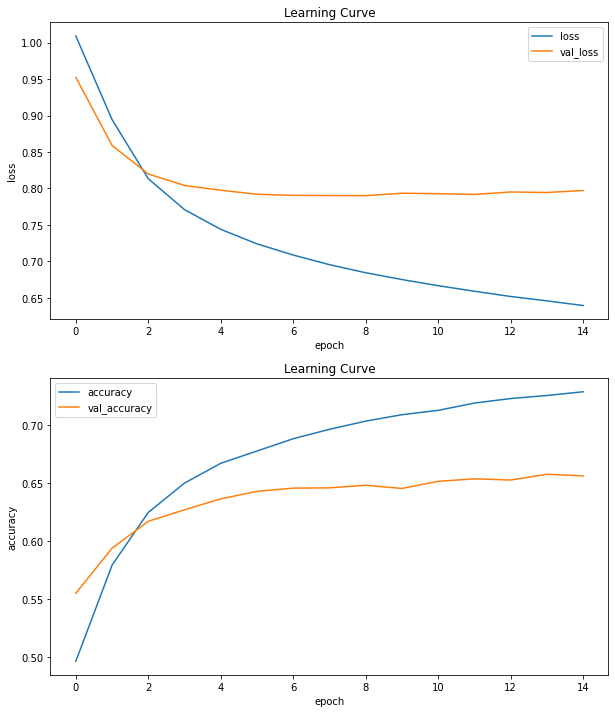

In [10]:
# Plot learning curve.
learning_curve(history_1)

### Other Models

In [11]:
# Compile model.
embedding_dim = 32

model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation="relu"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation="softmax")
])

model_2.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics='accuracy')

# Display model architecture.
model_2.summary()

# Train model.
history_2 = model_2.fit(train_padded, tf.one_hot(train_labels,3),
                    verbose=2,
                    epochs=15,
                    validation_data=(test_padded, tf.one_hot(test_labels,3)))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          640000    
                                                                 
 conv1d (Conv1D)             (None, None, 64)          6208      
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 646,403
Trainable params: 646,403
Non-trainable params: 0
________________________________________________

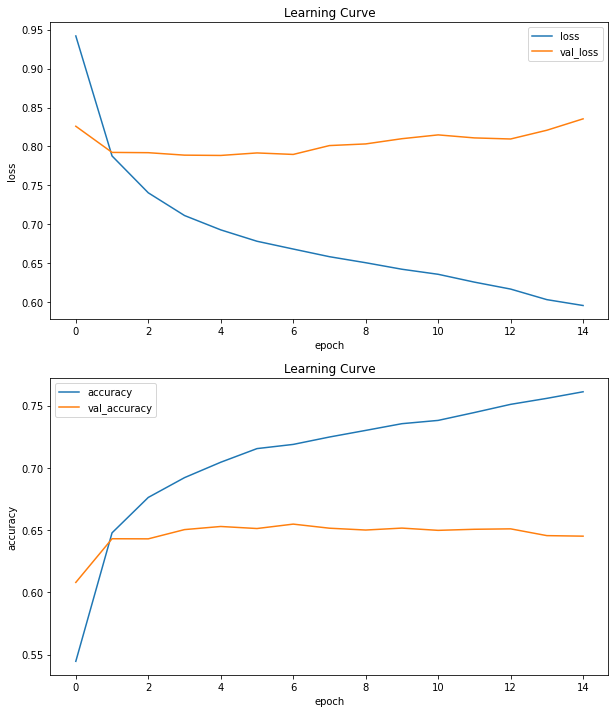

In [12]:
# Plot learning curve.
learning_curve(history_2)

In [13]:
# Compile model.
embedding_dim = 8

model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation="relu"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation="softmax")
])

model_3.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics='accuracy')

# Display model architecture.
model_3.summary()

# Train model.
history_3 = model_3.fit(train_padded, tf.one_hot(train_labels,3),
                    verbose=2,
                    epochs=15,
                    validation_data=(test_padded, tf.one_hot(test_labels,3)))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 8)           160000    
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          400       
                                                                 
 average_pooling1d (AverageP  (None, None, 16)         0         
 ooling1D)                                                       
                                                                 
 dropout_1 (Dropout)         (None, None, 16)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          1568      
                                                                 
 global_average_pooling1d_2   (None, 32)               0         
 (GlobalAveragePooling1D)                             

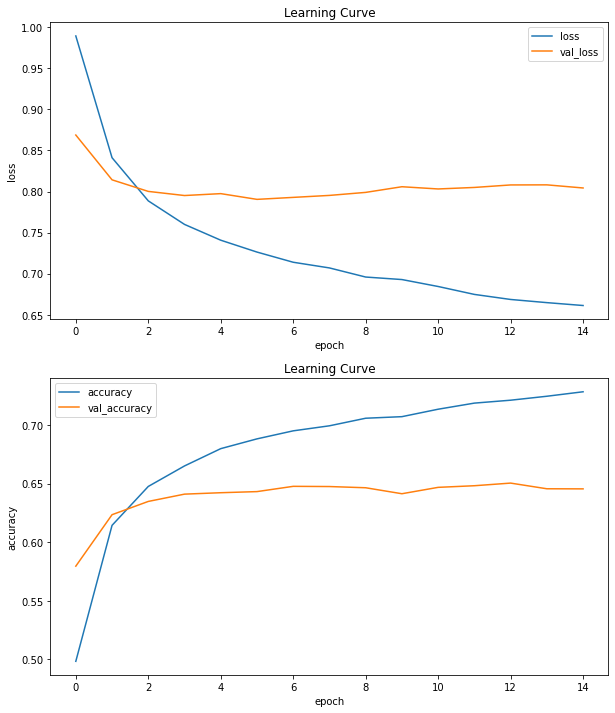

In [14]:
# Plot learning curve.
learning_curve(history_3)

In [15]:
# Compile model.
embedding_dim = 16

model_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation="relu"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation="softmax")
])

model_4.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics='accuracy')

# Display model architecture.
model_4.summary()

# Train model.
history_4 = model_4.fit(train_padded, tf.one_hot(train_labels,3),
                    verbose=2,
                    epochs=15,
                    validation_data=(test_padded, tf.one_hot(test_labels,3)))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 16)          320000    
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          1568      
                                                                 
 global_average_pooling1d_3   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 264       
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                      

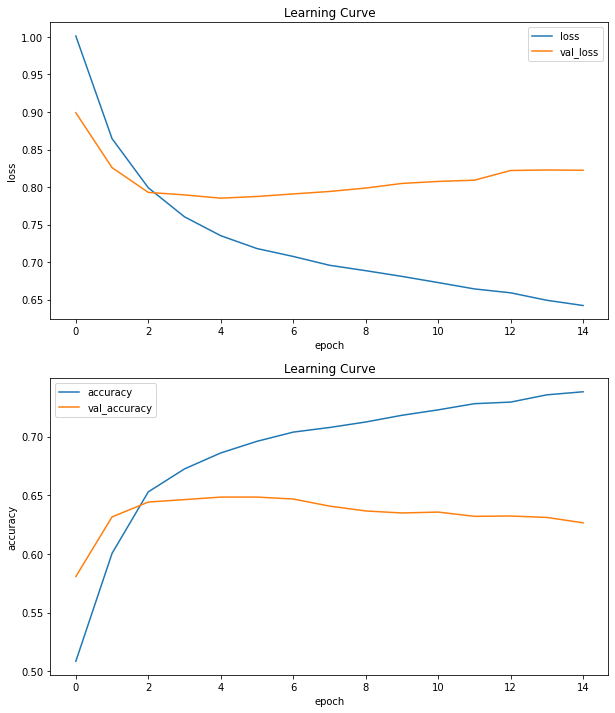

In [16]:
# Plot learning curve.
learning_curve(history_4)

In [17]:
# Compile model.
embedding_dim = 16

model_5 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation="softmax")
])

model_5.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics='accuracy')

# Display model architecture.
model_5.summary()

# Train model.
history_5 = model_5.fit(train_padded, tf.one_hot(train_labels,3),
                    verbose=2,
                    epochs=15,
                    validation_data=(test_padded, tf.one_hot(test_labels,3)))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 16)          320000    
                                                                 
 dropout_5 (Dropout)         (None, None, 16)          0         
                                                                 
 lstm (LSTM)                 (None, 2)                 152       
                                                                 
 dropout_6 (Dropout)         (None, 2)                 0         
                                                                 
 dense_5 (Dense)             (None, 3)                 9         
                                                                 
Total params: 320,161
Trainable params: 320,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1448/1448 - 23s - loss: 0.9921 - accu

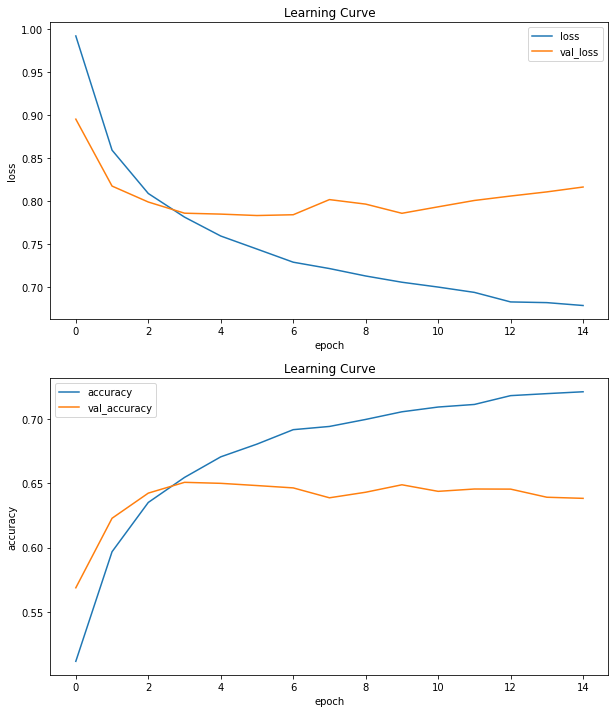

In [18]:
# Plot learning curve.
learning_curve(history_5)

### Summary

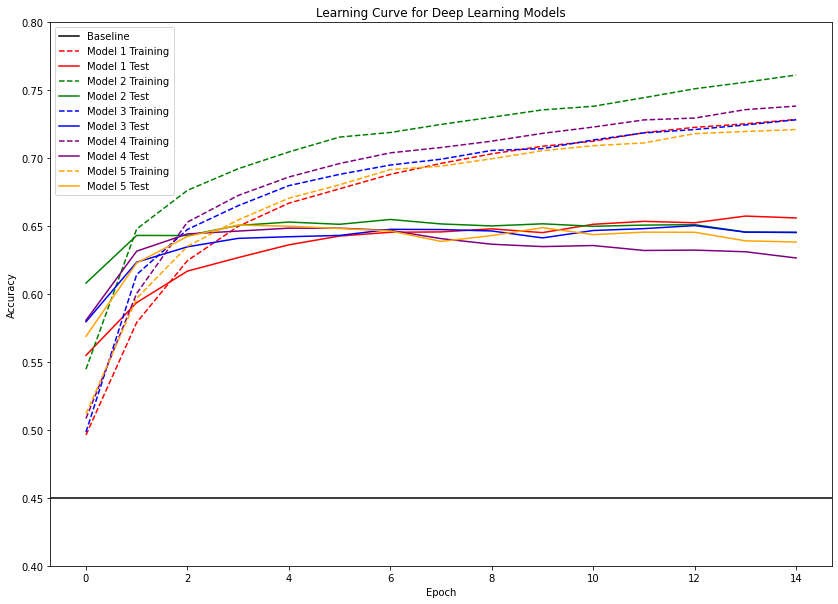

In [19]:
# Plot all five learning curves on the same axes.
plt.figure(figsize=(14,10))

plt.axhline(0.45, label='Baseline', color='black')
plt.plot(history_1.history['accuracy'], label='Model 1 Training', color='red', linestyle='dashed')
plt.plot(history_1.history['val_accuracy'], label='Model 1 Test', color='red')
plt.plot(history_2.history['accuracy'], label='Model 2 Training', color='green', linestyle='dashed')
plt.plot(history_2.history['val_accuracy'], label='Model 2 Test', color='green')
plt.plot(history_3.history['accuracy'], label='Model 3 Training', color='blue', linestyle='dashed')
plt.plot(history_3.history['val_accuracy'], label='Model 3 Test', color='blue')
plt.plot(history_4.history['accuracy'], label='Model 4 Training', color='purple', linestyle='dashed')
plt.plot(history_4.history['val_accuracy'], label='Model 4 Test', color='purple')
plt.plot(history_5.history['accuracy'], label='Model 5 Training', color='orange', linestyle='dashed')
plt.plot(history_5.history['val_accuracy'], label='Model 5 Test', color='orange')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim((0.4,0.8))
plt.title('Learning Curve for Deep Learning Models')

plt.show()
     

## Validation & Confusion Matrix

In [20]:
# Import validation data

with open("Val_text.txt") as f:
    val_text = pd.DataFrame([text for text in f], columns=["Content"])
with open("Val_labels.txt") as f:
    val_lab = pd.DataFrame([int(label.rstrip()) for label in f], columns=["Sentiment"])
sentiment_val_df = pd.concat([val_text, val_lab], axis=1).reset_index()[["Content","Sentiment"]]
sentiment_val_df.head(10)

,Content,Sentiment
0,Dark Souls 3 April Launch Date Confirmed With ...,1
1,"""National hot dog day, national tequila day, t...",2
2,When girls become bandwagon fans of the Packer...,0
3,@user I may or may not have searched it up on ...,1
4,Here's your starting TUESDAY MORNING Line up a...,1
5,"@user F-Main, are you in the office tomorrow i...",1
6,#US 1st Lady Michelle Obama speaking at the 20...,2
7,Omg this show is so predictable even for the 3...,0
8,"""What a round by Paul Dunne, good luck tomorro...",2
9,Irving Plaza NYC Blackout Saturday night. Got ...,1


In [21]:
# Transform Data

labels_val= list(sentiment_val_df["Sentiment"])
tweets_clean_val = []

for i in range(len(sentiment_val_df)):
    tweet_raw = sentiment_val_df["Content"].iloc[i]
    tweet_edit_1 = re.sub("@user", "", tweet_raw.lower())
    tweet_edit_2 = re.sub(r"\\u....", "", tweet_edit_1) # Remove unicode strings
    tweet_edit_3 = ""
    for word in tweet_edit_2.split(" "):
        if word not in stopword:
            tweet_edit_3 = tweet_edit_3 + " " + word # Remove stopwords
    tweet_edit_4 = re.sub(r"[^a-zA-Z0-9\s\.]", "", tweet_edit_3) # Filter punctuation
    tweet_edit_5 = re.sub(" \.|\. ", "", tweet_edit_4) # Get rid of fullstops that are outside of words (e.g. 'u.s' remains)
    tweets_clean_val.append(tweet_edit_5.strip())

# Tokenize and pad

val_sequences = tokenizer.texts_to_sequences(tweets_clean_val)
val_padded = pad_sequences(val_sequences, maxlen=max_length)

In [22]:
# Class Summary

print("VALIDATION SET")
print("Number of tweets is: {}.".format(len(labels_val)))
print("Number of positive tweets is: {} (or {:.1f}%).".format(sum(np.array(labels_val)==2),100*sum(np.array(labels_val)==2)/len(labels_val)))
print("Number of neutral tweets is: {} (or {:.1f}%).".format(sum(np.array(labels_val)==1),100*sum(np.array(labels_val)==1)/len(labels_val)))
print("Number of negative tweets is: {} (or {:.1f}%).".format(sum(np.array(labels_val)==0),100*sum(np.array(labels_val)==0)/len(labels_val)))

VALIDATION SET
Number of tweets is: 2000.
Number of positive tweets is: 819 (or 41.0%).
Number of neutral tweets is: 869 (or 43.5%).
Number of negative tweets is: 312 (or 15.6%).


In [23]:
# Use model to prediction validation data labels.

predicted_val = model_1.predict(val_padded)

63/63 [==============================] - 0s 2ms/step


In [24]:
# Tabulate model outputs, predictions, confidence and actual labels in DataFrame.

prediction_df = pd.DataFrame(predicted_val, columns = ["Predicted Negative", "Predicted Neutral", "Predicted Positive"])
prediction_df["Predicted"] = np.argmax(predicted_val, axis=1)
prediction_df["Confidence"] = np.max(predicted_val, axis=1)
prediction_df["Actual"] = labels_val
prediction_df

,Predicted Negative,Predicted Neutral,Predicted Positive,Predicted,Confidence,Actual
0,0.001807,0.679251,0.318942,1,0.679251,1
1,0.001039,0.037563,0.961399,2,0.961399,2
2,0.041749,0.699385,0.258866,1,0.699385,0
3,0.085168,0.702993,0.211839,1,0.702993,1
4,0.004043,0.650006,0.345952,1,0.650006,1
...,...,...,...,...,...,...
1995,0.004610,0.668379,0.327012,1,0.668379,1
1996,0.918330,0.075696,0.005975,0,0.918330,1
1997,0.045644,0.783046,0.171310,1,0.783046,2
1998,0.096834,0.725571,0.177594,1,0.725571,1


In [25]:
# Compute confusion matrix and display, along with accuracy across classes.

def conf_matrix_display(df_filtered):
    conf_matrix_filtered = np.array(tf.math.confusion_matrix(df_filtered["Actual"], df_filtered["Predicted"]))
    confusion_df_filtered = pd.DataFrame(conf_matrix_filtered, columns=["Predicted Negative", "Predicted Neutral", "Predicted Positive"])
    confusion_df_filtered.set_index([pd.Index(["Actual Negative", "Actual Neutral", "Actual Positive"]), ], inplace=True)
    confusion_df_filtered["Accuracy"] = [conf_matrix_filtered[i,i]/np.sum(conf_matrix_filtered, axis=1)[i] for i in range(3)]
    # Here we consider "positive" and "negative" together as "signal".
    confusion_df_filtered["False Signal Rate"] = [conf_matrix_filtered[0,2]/np.sum(conf_matrix_filtered, axis=1)[0],
                                        (conf_matrix_filtered[1,0]+conf_matrix_filtered[1,2])/np.sum(conf_matrix_filtered, axis=1)[1],
                                        conf_matrix_filtered[0,0]/np.sum(conf_matrix_filtered, axis=1)[2]]
    display(confusion_df_filtered)
    print("Total sample size: ", np.sum(conf_matrix_filtered.flatten()))
    print("Total accuracy: ", np.sum(conf_matrix_filtered.diagonal())/np.sum(conf_matrix_filtered.flatten()))

In [26]:
# Display unfiltered confusion matrix.
print("Unfiltered confusion matrix")
conf_matrix_display(prediction_df)

Unfiltered confusion matrix


,Predicted Negative,Predicted Neutral,Predicted Positive,Accuracy,False Signal Rate
Actual Negative,126,149,37,0.403846,0.118590
Actual Neutral,58,647,164,0.744534,0.255466
Actual Positive,29,246,544,0.664225,0.153846


Total sample size:  2000
Total accuracy:  0.6585


In [27]:
# Display confusion matrix for prediction confidence over 0.7.
print("Confusion matrix; confidence > 0.7")
conf_matrix_display(prediction_df[prediction_df["Confidence"] > 0.7])

Confusion matrix; confidence > 0.7


,Predicted Negative,Predicted Neutral,Predicted Positive,Accuracy,False Signal Rate
Actual Negative,72,50,8,0.553846,0.061538
Actual Neutral,20,367,61,0.819196,0.180804
Actual Positive,6,93,384,0.795031,0.149068


Total sample size:  1061
Total accuracy:  0.7756833176248822


In [28]:
# Display confusion matrix for prediction confidence over 0.8.
print("Confusion matrix; confidence > 0.8")
conf_matrix_display(prediction_df[prediction_df["Confidence"] > 0.8])

Confusion matrix; confidence > 0.8


,Predicted Negative,Predicted Neutral,Predicted Positive,Accuracy,False Signal Rate
Actual Negative,52,24,4,0.650000,0.050000
Actual Neutral,13,208,35,0.812500,0.187500
Actual Positive,4,47,306,0.857143,0.145658


Total sample size:  693
Total accuracy:  0.8167388167388168


In [29]:
# Display confusion matrix for prediction confidence over 0.9.
print("Confusion matrix; confidence > 0.9")
conf_matrix_display(prediction_df[prediction_df["Confidence"] > 0.9])

Confusion matrix; confidence > 0.9


,Predicted Negative,Predicted Neutral,Predicted Positive,Accuracy,False Signal Rate
Actual Negative,30,4,2,0.833333,0.055556
Actual Neutral,5,91,18,0.798246,0.201754
Actual Positive,2,15,195,0.919811,0.141509


Total sample size:  362
Total accuracy:  0.8729281767955801


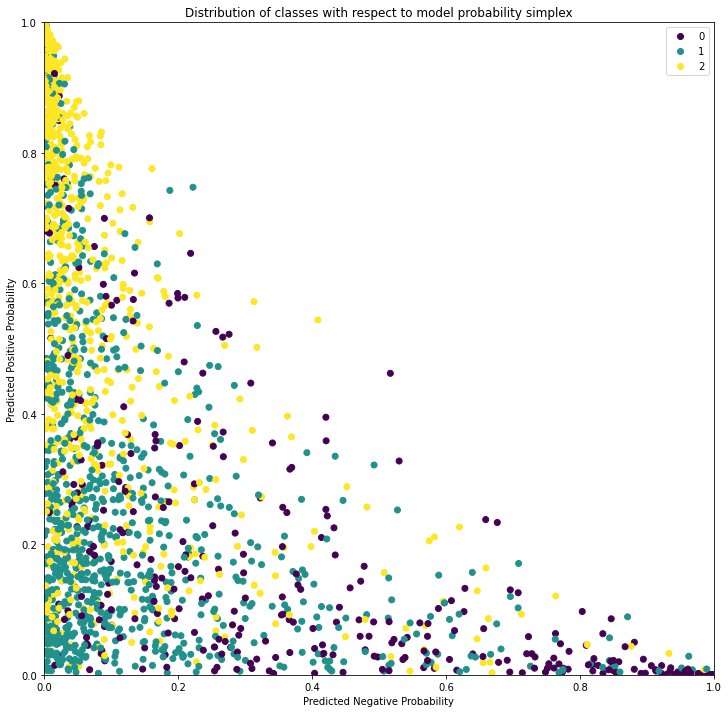

In [30]:
# Plot classes across model probability predictions.
plt.figure(figsize=(12,12))
scatter = plt.scatter(data=prediction_df, x="Predicted Negative", y="Predicted Positive",c="Actual")

#Formatting
plt.xlim((0,1))
plt.xlabel("Predicted Negative Probability")
plt.ylabel("Predicted Positive Probability")
plt.ylim((0,1))
plt.title("Distribution of classes with respect to model probability simplex")
handles, labels = scatter.legend_elements()
plt.legend(handles, [0,1,2])

plt.show()

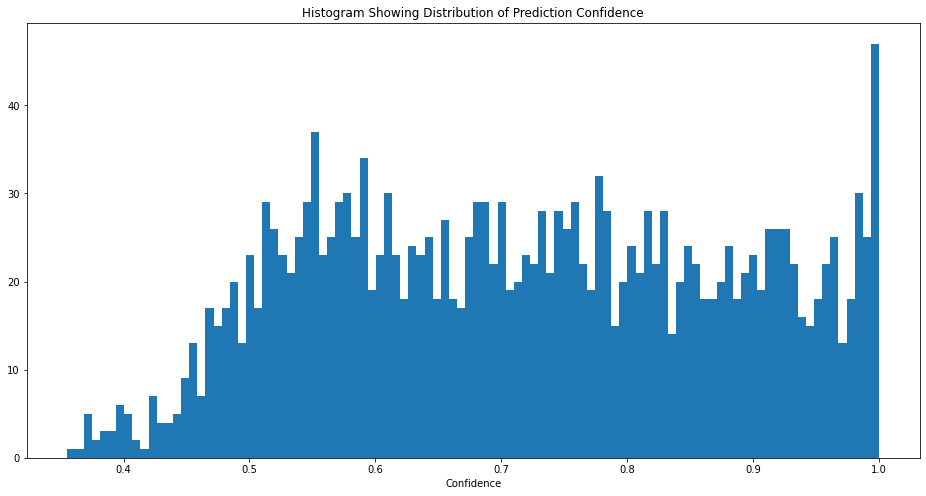

In [31]:
# Plot distribution of confidence.
plt.figure(figsize=(16,8))
plt.hist(np.max(predicted_val, axis=1), bins = 100)

# Formatting
plt.xlabel("Confidence")
plt.title("Histogram Showing Distribution of Prediction Confidence")

plt.show()

# Sentiment Analysis

In [58]:
# Read and format the twitter scrape .csv file
# Add the .csv file to the workspace or this won't work

tweets_df = pd.read_csv("Twitter Scrape 2_Full.csv", usecols=['ID', 'Date', 'Likes', 'Replies', 'Retweets', 'User ID', 'Username', 
                                                                 'Followers', 'Verified', 'Content', 'Time', 'Category'],
                        encoding="UTF-8")
tweets_df["Time"] = pd.to_datetime(tweets_df["Time"], format='%H:%M:%S').dt.time
tweets_df["Date"] = pd.to_datetime(tweets_df["Date"], format='%Y-%m-%d').dt.date


tweets_clean = []
for i in range(len(tweets_df)):
    tweet_raw = tweets_df["Content"][i]
    tweet_edit_1 = re.sub("@user", "", tweet_raw.lower())
    tweet_edit_2 = re.sub(r"\\u....", "", tweet_edit_1) # Remove unicode strings
    tweet_edit_3 = ""
    for word in tweet_edit_2.split(" "):
        if word not in stopword:
            tweet_edit_3 = tweet_edit_3 + " " + word # Remove stopwords
    tweet_edit_4 = re.sub(r"[^a-zA-Z0-9\s\.]", "", tweet_edit_3) # Filter punctuation
    tweet_edit_5 = re.sub(" \.|\. ", "", tweet_edit_4) # Get rid of fullstops that are outside of words (e.g. 'u.s' remains)
    tweets_clean.append(tweet_edit_5.strip())

# Preprocessing hyperparameters.

vocab_size = 20000
max_length = 20

# Tokenize text data, converting to integers.

sequences = tokenizer.texts_to_sequences(tweets_clean)

# Pad sequences to standardise input sequence length.

padded_sequences = pad_sequences(sequences, maxlen=max_length)

In [59]:
# Use model to create predictions.

predicted_tweets = model_1.predict(padded_sequences)
tweets_df["Negative Probability"] = predicted_tweets[:,0]
tweets_df["Neutral Probability"] = predicted_tweets[:,1]
tweets_df["Positive Probability"] = predicted_tweets[:,2]

30687/30687 [==============================] - 57s 2ms/step


In [60]:
tweets_df.columns

Index(['ID', 'Date', 'Time', 'Likes', 'Replies', 'Retweets', 'User ID',
       'Username', 'Followers', 'Verified', 'Content', 'Category',
       'Negative Probability', 'Neutral Probability', 'Positive Probability'],
      dtype='object')

In [68]:
# Save predictions via .csv.
tweets_df.to_csv("Twitter Scrape 2_Sentiment_Full.csv", index=False, usecols=['ID', 'Date', 'Time', 'Likes', 'Replies', 'Retweets', 'User ID',
       'Username', 'Followers', 'Verified', 'Content', 'Category',
       'Negative Probability', 'Neutral Probability', 'Positive Probability'], )